<a href="https://colab.research.google.com/github/ocjorge/CarDetection/blob/main/CarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==============================================================================
# PASO -1: MONTAR GOOGLE DRIVE
# ==============================================================================
print("Paso -1: Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

Paso -1: Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ==============================================================================
# PASO 0: INSTALACIÓN DE LIBRERÍAS NECESARIAS
# ==============================================================================
print("\nPaso 0: Instalando librerías...")
!pip install ultralytics -q
!pip install pyyaml -q

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import zipfile
from ultralytics import YOLO
import ultralytics
from google.colab import files

print("Librerías instaladas y módulos importados.")
print(f"Ultralytics versión: {ultralytics.__version__}")


Paso 0: Instalando librerías...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo setting

In [4]:
# ==============================================================================
# PASO 0.5: CONFIGURACIÓN DE RUTAS DE DRIVE Y DESCOMPRESIÓN DEL DATASET (TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...")

# --------- MODIFICA ESTAS VARIABLES SI ES NECESARIO ---------
# Ruta en tu Google Drive donde está el archivo ZIP de tu dataset DE VEHÍCULOS
DRIVE_DATASET_ZIP_PATH = "/content/vehicle_dataset.zip"  # <<<<<<< CAMBIA ESTO a la ruta de tu ZIP de VEHÍCULOS

COLAB_BASE_PATH = "/content/"
EXTRACT_DIR_NAME = "vehicle_dataset_extracted"
EXTRACT_TO_DIR = os.path.join(COLAB_BASE_PATH, EXTRACT_DIR_NAME)

# Nombre de la carpeta principal DENTRO del ZIP que contiene 'train', 'valid', etc.
EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP = "vehicle dataset" # <<<<<<< AJUSTA ESTO según la estructura de tu ZIP de VEHÍCULOS
# -----------------------------------------------------------

DRIVE_WORKING_DIR_BASE = "/content/drive/MyDrive/YOLO_FineTuning_Results"
os.makedirs(DRIVE_WORKING_DIR_BASE, exist_ok=True)
COLAB_WORKING_DIR = os.path.join(COLAB_BASE_PATH, "yolo_finetune_output")

if os.path.exists(DRIVE_DATASET_ZIP_PATH):
    print(f"Archivo ZIP encontrado en Drive: {DRIVE_DATASET_ZIP_PATH}")
    print(f"Extrayendo a: {EXTRACT_TO_DIR}...")
    os.makedirs(EXTRACT_TO_DIR, exist_ok=True)
    !unzip -q -o "{DRIVE_DATASET_ZIP_PATH}" -d "{EXTRACT_TO_DIR}"
    print("Descompresión completada.")

    if EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP:
        BASE_DATASET_PATH = os.path.join(EXTRACT_TO_DIR, EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP)
    else:
        BASE_DATASET_PATH = EXTRACT_TO_DIR

    print(f"El dataset base (vehículos) ahora está en: {BASE_DATASET_PATH}")
    if not os.path.exists(BASE_DATASET_PATH):
        raise FileNotFoundError(f"Dataset de vehículos no encontrado en {BASE_DATASET_PATH} después de la extracción.")
else:
    raise FileNotFoundError(f"Archivo ZIP de vehículos {DRIVE_DATASET_ZIP_PATH} no encontrado en Google Drive.")



Paso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...
Archivo ZIP encontrado en Drive: /content/vehicle_dataset.zip
Extrayendo a: /content/vehicle_dataset_extracted...
Descompresión completada.
El dataset base (vehículos) ahora está en: /content/vehicle_dataset_extracted/vehicle dataset


In [5]:
# ==============================================================================
# PASO 1: DEFINICIÓN DE RUTAS Y VARIABLES PRINCIPALES (PARA EL DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 1: Definiendo rutas y variables...")

TRAIN_DIR = os.path.join(BASE_DATASET_PATH, 'train')
VALID_DIR = os.path.join(BASE_DATASET_PATH, 'valid')

# ----- CLASES EN TU DATASET DE VEHÍCULOS (para el data.yaml y entrenamiento) -----
# Estas son las clases que tu dataset de vehículos contiene y que el modelo aprenderá/refinará.
CLASSES_IN_VEHICLE_DATASET = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van'] # <<<< AJUSTA ESTO EXACTAMENTE a tu dataset
NUM_CLASSES_VEHICLE_DATASET = len(CLASSES_IN_VEHICLE_DATASET)
# ------------------------------------------------------------------------------------

# ----- CLASES QUE ESPERAMOS DETECTAR EN INFERENCIA (incluye las de COCO) -----
# El modelo base yolov8n.pt conoce las clases de COCO.
# Después del fine-tuning, el modelo debería reconocer tus vehículos Y las clases de COCO.
# "pothole" NO está en COCO. Si quieres "pothole", NECESITAS añadir datos para ello.
CLASSES_FOR_INFERENCE = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', # Comunes de COCO
                         'threewheel', 'van'] # Específicas de tu dataset
# NOTA: 'pothole' se omite aquí porque no tenemos datos para ello.
# Si TUVIERAS un dataset de potholes y lo incluyeras en el entrenamiento, lo añadirías aquí.
# ------------------------------------------------------------------------------------


os.makedirs(COLAB_WORKING_DIR, exist_ok=True)
DATA_YAML_PATH = os.path.join(COLAB_WORKING_DIR, 'vehicle_data.yaml') # YAML para tu dataset de vehículos

print(f"Directorio de entrenamiento (vehículos): {TRAIN_DIR}")
print(f"Directorio de validación (vehículos): {VALID_DIR}")
print(f"Clases en TU dataset de vehículos (para entrenamiento): {CLASSES_IN_VEHICLE_DATASET}")
print(f"Clases esperadas en inferencia (aprox): {CLASSES_FOR_INFERENCE}")
print(f"Archivo YAML se guardará en: {DATA_YAML_PATH}")
print(f"Los resultados del entrenamiento (runs) se guardarán temporalmente en: {COLAB_WORKING_DIR}/runs")

# Verificaciones de directorios
for d_path in [TRAIN_DIR, VALID_DIR]:
    if not os.path.exists(d_path) or \
       not os.path.exists(os.path.join(d_path, 'images')) or \
       not os.path.exists(os.path.join(d_path, 'labels')):
        print(f"ADVERTENCIA: El directorio {d_path} o sus subcarpetas 'images'/'labels' no existen o están mal configurados.")


Paso 1: Definiendo rutas y variables...
Directorio de entrenamiento (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/train
Directorio de validación (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/valid
Clases en TU dataset de vehículos (para entrenamiento): ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']
Clases esperadas en inferencia (aprox): ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', 'threewheel', 'van']
Archivo YAML se guardará en: /content/yolo_finetune_output/vehicle_data.yaml
Los resultados del entrenamiento (runs) se guardarán temporalmente en: /content/yolo_finetune_output/runs



Paso 2: Exploración de datos (dataset de vehículos)...


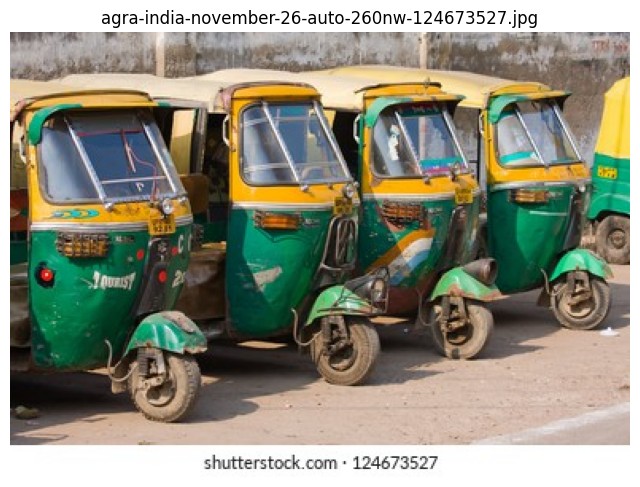


Contando etiquetas en el conjunto de entrenamiento de VEHÍCULOS (/content/vehicle_dataset_extracted/vehicle dataset/train/labels)...

Distribución de clases en el conjunto de entrenamiento (VEHÍCULOS):
car: 461
threewheel: 482
bus: 403
truck: 478
motorbike: 483
van: 378


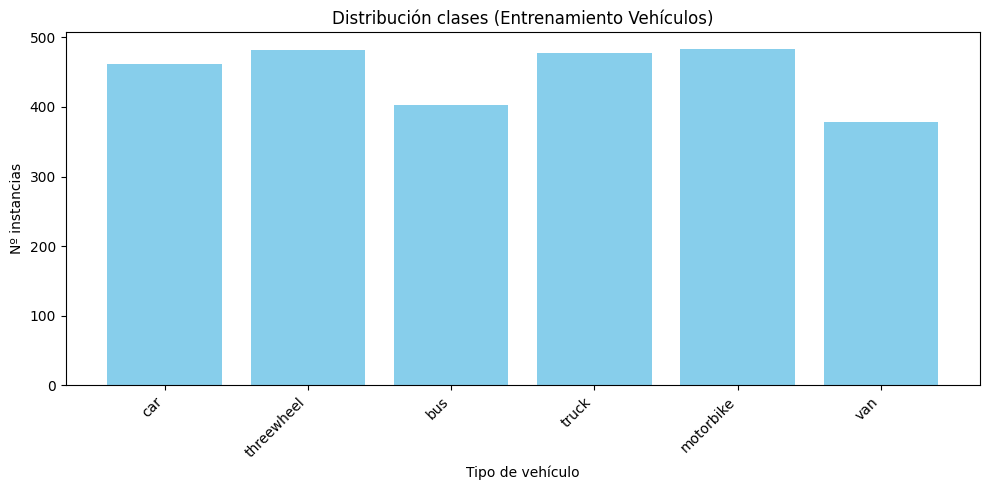

In [6]:
# ==============================================================================
# PASO 2: EXPLORACIÓN DE DATOS (DE TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 2: Exploración de datos (dataset de vehículos)...")
def image_plot(file_path): # Misma función
    img = cv2.imread(file_path);
    if img is None: print(f"Error: No se pudo cargar la imagen {file_path}"); return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); plt.figure(figsize=(8,8))
    plt.imshow(img_rgb); plt.title(os.path.basename(file_path)); plt.axis('off'); plt.show()
    return img_rgb

train_images_path = os.path.join(TRAIN_DIR, 'images')
try:
    sample_images_list = glob.glob(os.path.join(train_images_path, '*.jpg')) + glob.glob(os.path.join(train_images_path, '*.png'))
    if sample_images_list: image_plot(sample_images_list[0])
    else: print(f"No se encontraron imágenes en {train_images_path}")
except Exception as e: print(f"Error listando imágenes: {e}")

def count_labels_in_files(label_files_dir, num_classes, class_names_map): # Misma función
    counts = {name: 0 for name in class_names_map}
    if not os.path.exists(label_files_dir): print(f"Dir de etiquetas no encontrado: {label_files_dir}"); return counts
    label_files = glob.glob(os.path.join(label_files_dir, '*.txt'))
    if not label_files: print(f"No archivos .txt en {label_files_dir}"); return counts
    for file_path in label_files:
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.split();
                    if parts:
                        class_id = int(parts[0])
                        if 0 <= class_id < num_classes: counts[class_names_map[class_id]] += 1
                        else: print(f"ID clase fuera de rango ({class_id}) en: {file_path}")
        except Exception as e: print(f"Error procesando {file_path}: {e}")
    return counts

train_labels_dir = os.path.join(TRAIN_DIR, 'labels')
print(f"\nContando etiquetas en el conjunto de entrenamiento de VEHÍCULOS ({train_labels_dir})...")
label_counts_dict = count_labels_in_files(train_labels_dir, NUM_CLASSES_VEHICLE_DATASET, CLASSES_IN_VEHICLE_DATASET)

print("\nDistribución de clases en el conjunto de entrenamiento (VEHÍCULOS):")
for class_name, count in label_counts_dict.items(): print(f"{class_name}: {count}")
if sum(label_counts_dict.values()) > 0 :
    plt.figure(figsize=(10, 5)); plt.bar(label_counts_dict.keys(), label_counts_dict.values(), color='skyblue')
    plt.xlabel('Tipo de vehículo'); plt.ylabel('Nº instancias'); plt.title('Distribución clases (Entrenamiento Vehículos)')
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
else: print("No se encontraron etiquetas para graficar.")

In [7]:
# ==============================================================================
# PASO 3: CREACIÓN DEL ARCHIVO data.yaml (PARA TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 3: Creando el archivo data.yaml para el dataset de vehículos...")
data_yaml_content = {
    'path': BASE_DATASET_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'nc': NUM_CLASSES_VEHICLE_DATASET,
    'names': CLASSES_IN_VEHICLE_DATASET # Solo las clases de tu dataset de vehículos
}
try:
    with open(DATA_YAML_PATH, 'w') as f: yaml.dump(data_yaml_content, f, sort_keys=False, Dumper=yaml.SafeDumper)
    print(f"Archivo data.yaml creado en {DATA_YAML_PATH}")
    with open(DATA_YAML_PATH, 'r') as f: print(f"\nContenido de data.yaml:\n{f.read()}")
except Exception as e: print(f"Error al crear data.yaml: {e}")



Paso 3: Creando el archivo data.yaml para el dataset de vehículos...
Archivo data.yaml creado en /content/yolo_finetune_output/vehicle_data.yaml

Contenido de data.yaml:
path: /content/vehicle_dataset_extracted/vehicle dataset
train: train/images
val: valid/images
nc: 6
names:
- car
- threewheel
- bus
- truck
- motorbike
- van



In [8]:
# ==============================================================================
# PASO 4: FINE-TUNING DEL MODELO YOLOv8 CON TU DATASET DE VEHÍCULOS
# ==============================================================================
print("\nPaso 4: Fine-tuning del modelo YOLOv8n.pt con tu dataset de vehículos...")
print("\nRealizando chequeo de Ultralytics..."); ultralytics.checks()

model = YOLO("yolov8n.pt") # Empezamos con el modelo pre-entrenado en COCO
print(f"\nModelo YOLO('yolov8n.pt') cargado. Este modelo ya conoce clases de COCO como 'person', 'dog', 'bicycle', 'car'.")
print("Ahora haremos fine-tuning con tu dataset para mejorar/añadir tus clases de vehículos.")

BATCH_SIZE = 16
EPOCHS = 30 # Para fine-tuning, a veces menos épocas son suficientes, pero monitorea. Ajusta según sea necesario.
IMG_SIZE = 640
PROJECT_NAME_TRAIN = "finetune_vehicles"
EXPERIMENT_NAME_TRAIN = "exp_vehicles_on_coco_base"

print(f"Iniciando fine-tuning con batch_size={BATCH_SIZE}, epochs={EPOCHS}, imgsz={IMG_SIZE}")
print(f"Usando data YAML: {DATA_YAML_PATH} (con tus clases de vehículos)")
print(f"Los resultados se guardarán en: {COLAB_WORKING_DIR}/runs/{PROJECT_NAME_TRAIN}/{EXPERIMENT_NAME_TRAIN}")

if not os.path.exists(DATA_YAML_PATH):
    print(f"ERROR CRÍTICO: El archivo {DATA_YAML_PATH} no existe. No se puede entrenar.")
else:
    try:
        results = model.train(
            data=DATA_YAML_PATH, # YAML específico de tu dataset de vehículos
            batch=BATCH_SIZE,
            epochs=EPOCHS,
            imgsz=IMG_SIZE,
            project=os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN),
            name=EXPERIMENT_NAME_TRAIN,
            patience=10 # Early stopping
        )
        print("Fine-tuning completado.")
        potential_dirs = glob.glob(os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN, EXPERIMENT_NAME_TRAIN + '*'))
        LATEST_RUN_DIR = max(potential_dirs, key=os.path.getctime) if potential_dirs else None

        if LATEST_RUN_DIR:
            print(f"Resultados del fine-tuning guardados en: {LATEST_RUN_DIR}")
            BEST_MODEL_PATH_TRAIN = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
            print(f"El mejor modelo (fine-tuned) se guardó en: {BEST_MODEL_PATH_TRAIN}")
        else:
            BEST_MODEL_PATH_TRAIN = None; print("No se pudo determinar la carpeta del último run.")
    except Exception as e:
        print(f"Ocurrió un error durante el fine-tuning: {e}"); import traceback; traceback.print_exc()
        BEST_MODEL_PATH_TRAIN = None


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 45.8/112.6 GB disk)


100%|██████████| 6.25M/6.25M [00:00<00:00, 78.0MB/s]



Modelo YOLO('yolov8n.pt') cargado. Este modelo ya conoce clases de COCO como 'person', 'dog', 'bicycle', 'car'.
Ahora haremos fine-tuning con tu dataset para mejorar/añadir tus clases de vehículos.
Iniciando fine-tuning con batch_size=16, epochs=30, imgsz=640
Usando data YAML: /content/yolo_finetune_output/vehicle_data.yaml (con tus clases de vehículos)
Los resultados se guardarán en: /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_finetune_output/vehicle_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=Fal

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    752482  ultralytics.nn.modules.head.Detect           [6, [64, 128, 256]]           
Model summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Transf

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1421.5±578.2 MB/s, size: 62.0 KB)


train: Scanning /content/vehicle_dataset_extracted/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:01<00:00, 1808.58it/s]

train: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1152.7±1309.3 MB/s, size: 183.8 KB)


val: Scanning /content/vehicle_dataset_extracted/vehicle dataset/valid/labels... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:01<00:00, 515.10it/s]

val: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car55.jpg: corrupt JPEG restored and saved


val: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/valid/labels.cache
Plotting labels to /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.14G     0.6336      2.154      1.145         20        640: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


                   all        900       1150      0.769      0.705      0.832      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.02G      0.666      1.433      1.153         15        640: 100%|██████████| 132/132 [00:46<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]


                   all        900       1150      0.764      0.654      0.786      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.03G     0.7129        1.3      1.174         11        640: 100%|██████████| 132/132 [00:47<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]


                   all        900       1150      0.706      0.706      0.736      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.05G     0.7007      1.193      1.176         11        640: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]


                   all        900       1150      0.915       0.78      0.895      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.06G     0.6637      1.062      1.145         11        640: 100%|██████████| 132/132 [00:46<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]


                   all        900       1150      0.776      0.683      0.786      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.08G     0.6524     0.9426      1.137         15        640: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


                   all        900       1150      0.877      0.841      0.929      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.09G     0.6229     0.8941       1.12         11        640: 100%|██████████| 132/132 [00:46<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.98it/s]

                   all        900       1150      0.904      0.841      0.921      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.11G     0.6088     0.8567      1.107          7        640: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.96it/s]


                   all        900       1150      0.863      0.832      0.904      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.13G      0.589     0.7772      1.094         11        640: 100%|██████████| 132/132 [00:46<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]

                   all        900       1150      0.882      0.847      0.932      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.14G     0.5833      0.744       1.08         11        640: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]

                   all        900       1150      0.873      0.844      0.931       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.16G     0.5708     0.7276       1.08          8        640: 100%|██████████| 132/132 [00:44<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.93it/s]

                   all        900       1150      0.915      0.875      0.947      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.18G     0.5576     0.6912      1.071         15        640: 100%|██████████| 132/132 [00:46<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.96it/s]

                   all        900       1150      0.942      0.892      0.959      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       3.2G     0.5373     0.6554      1.065         13        640: 100%|██████████| 132/132 [00:43<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


                   all        900       1150      0.908      0.887      0.955      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.21G     0.5427     0.6285      1.064         13        640: 100%|██████████| 132/132 [00:46<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]

                   all        900       1150      0.939      0.881      0.954      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.23G       0.51     0.5998      1.043         14        640: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]

                   all        900       1150      0.927      0.911      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.25G     0.5187     0.5859      1.048         12        640: 100%|██████████| 132/132 [00:48<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.15it/s]

                   all        900       1150       0.95      0.898      0.964      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.26G     0.4994     0.5528      1.045         10        640: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]

                   all        900       1150      0.939      0.914      0.966      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.28G     0.4826     0.5505      1.032         17        640: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all        900       1150      0.957      0.907      0.968      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       3.3G     0.4807     0.5186      1.029         11        640: 100%|██████████| 132/132 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.74it/s]

                   all        900       1150      0.946      0.928      0.972      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.31G      0.475     0.5067      1.023         14        640: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.29it/s]

                   all        900       1150      0.956      0.913      0.971      0.882


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.33G     0.3777     0.4126     0.9593          4        640: 100%|██████████| 132/132 [00:46<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]

                   all        900       1150      0.937      0.931      0.967      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.35G     0.3725     0.3778     0.9494          4        640: 100%|██████████| 132/132 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.03it/s]

                   all        900       1150      0.948       0.93      0.973      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.37G     0.3545     0.3593     0.9335          5        640: 100%|██████████| 132/132 [00:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


                   all        900       1150      0.962      0.925      0.975      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.38G     0.3393     0.3364     0.9286          4        640: 100%|██████████| 132/132 [00:41<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]

                   all        900       1150      0.964      0.934      0.977      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       3.4G     0.3268     0.3172     0.9192          7        640: 100%|██████████| 132/132 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.70it/s]

                   all        900       1150      0.956      0.936      0.976      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.42G     0.3091     0.2979     0.9106          4        640: 100%|██████████| 132/132 [00:43<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


                   all        900       1150      0.953      0.935      0.976      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.43G      0.302      0.292     0.9008          4        640: 100%|██████████| 132/132 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.46it/s]

                   all        900       1150      0.966      0.933      0.979      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.45G     0.2921     0.2732     0.8957          4        640: 100%|██████████| 132/132 [00:44<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.02it/s]

                   all        900       1150      0.969       0.94      0.979      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.47G     0.2875     0.2709     0.8972          5        640: 100%|██████████| 132/132 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.34it/s]

                   all        900       1150      0.964       0.95      0.981      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.48G     0.2736     0.2526     0.8831          6        640: 100%|██████████| 132/132 [00:43<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.82it/s]

                   all        900       1150      0.965       0.95       0.98      0.911



30 epochs completed in 0.461 hours.
Optimizer stripped from /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/last.pt, 6.2MB
Optimizer stripped from /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/best.pt, 6.2MB

Validating /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


                   all        900       1150      0.965       0.95       0.98      0.911
                   car        182        201      0.939      0.925       0.97      0.937
            threewheel        167        227      0.995      0.955      0.989      0.912
                   bus        162        185      0.977      0.984       0.99      0.957
                 truck        123        151      0.954       0.98      0.986      0.924
             motorbike        165        216       0.97      0.903      0.957      0.769
                   van        157        170      0.953      0.953      0.987      0.966
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
Fine-tuning completado.
Resultados del fine-tuning guardados en: /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base
El mejor modelo (fine-tuned) se guardó en: /content/yol


Paso 5: Evaluación e inferencia con el modelo fine-tuned...
Usando el modelo fine-tuned: /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/best.pt
Clases conocidas por el modelo fine-tuned (trained_model.names): {0: 'car', 1: 'threewheel', 2: 'bus', 3: 'truck', 4: 'motorbike', 5: 'van'}

Evaluando el modelo en el conjunto de validación (de vehículos)...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1598.2±608.1 MB/s, size: 113.7 KB)


val: Scanning /content/vehicle_dataset_extracted/vehicle dataset/valid/labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car55.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:15<00:00,  3.76it/s]


                   all        900       1150      0.963       0.95       0.98      0.911
                   car        182        201      0.938      0.925       0.97      0.937
            threewheel        167        227      0.995      0.955       0.99      0.911
                   bus        162        185      0.975      0.984       0.99      0.957
                 truck        123        151       0.95       0.98      0.986      0.923
             motorbike        165        216      0.965      0.903      0.957      0.771
                   van        157        170      0.955      0.953      0.987      0.965
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val
Métricas de validación (mAP50 para clases de vehículos): 0.979966011823969

Realizando inferencia. El modelo debería detectar tus vehículos y clases de COCO.
ADVERTENCIA: 'pothole' NO será detectado ya que no estaba en COCO ni en tu dataset de vehículos.
Usando 

<ipython-input-9-1b0f346ef629>:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(trained_model.names))


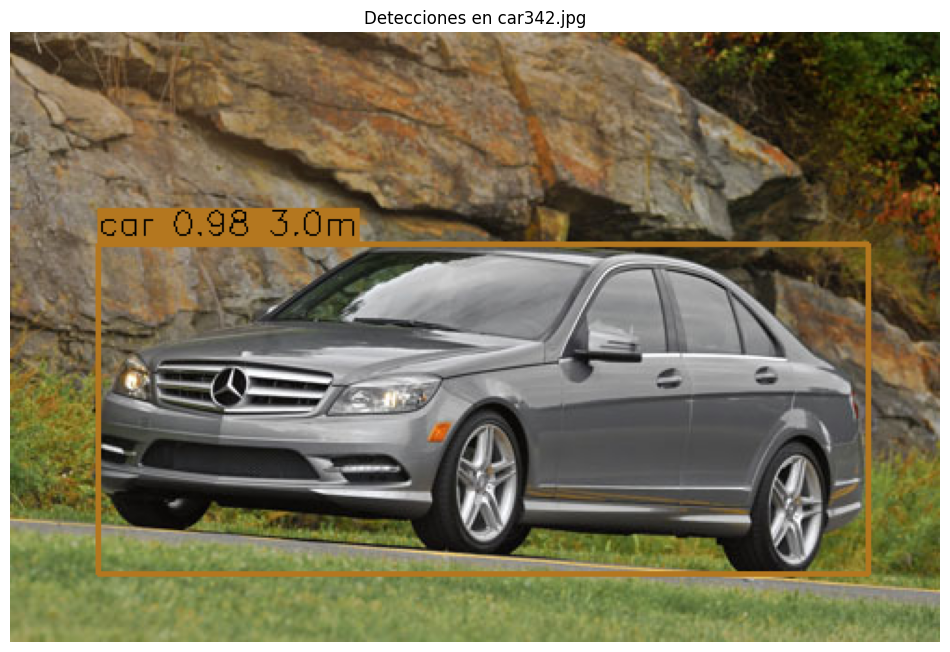

In [9]:
# ==============================================================================
# PASO 5: EVALUACIÓN E INFERENCIA CON EL MODELO FINE-TUNED
# ==============================================================================
print("\nPaso 5: Evaluación e inferencia con el modelo fine-tuned...")

BEST_MODEL_PATH = None # Iniciar BEST_MODEL_PATH
if 'BEST_MODEL_PATH_TRAIN' in locals() and BEST_MODEL_PATH_TRAIN and os.path.exists(BEST_MODEL_PATH_TRAIN):
    BEST_MODEL_PATH = BEST_MODEL_PATH_TRAIN
# ... (lógica para encontrar BEST_MODEL_PATH si no está en BEST_MODEL_PATH_TRAIN, como en tu script original)
elif 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.exists(os.path.join(LATEST_RUN_DIR, 'weights/best.pt')):
     BEST_MODEL_PATH = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
else:
    search_pattern = os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN, EXPERIMENT_NAME_TRAIN + '*', 'weights/best.pt')
    model_files = glob.glob(search_pattern)
    if model_files:
        model_files.sort(key=lambda x: os.path.getmtime(os.path.dirname(os.path.dirname(x))))
        BEST_MODEL_PATH = model_files[-1]

if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Usando el modelo fine-tuned: {BEST_MODEL_PATH}")
    # Al cargar el modelo, automáticamente conoce las clases con las que fue entrenado
    # (las de COCO originalmente + las que se refinaron/aprendieron de tu dataset)
    trained_model = YOLO(BEST_MODEL_PATH)

    # Los nombres de clase en trained_model.names ahora incluirán
    # una combinación de las clases de COCO y las clases de tu dataset.
    # Es importante verificar esto si hay solapamientos (ej. 'car').
    print(f"Clases conocidas por el modelo fine-tuned (trained_model.names): {trained_model.names}")


    print("\nEvaluando el modelo en el conjunto de validación (de vehículos)...")
    try:
        # La validación se hará con el data.yaml de vehículos,
        # por lo que las métricas serán para esas clases específicas.
        metrics = trained_model.val(data=DATA_YAML_PATH)
        if metrics and hasattr(metrics, 'box') and hasattr(metrics.box, 'map50'):
             print("Métricas de validación (mAP50 para clases de vehículos):", metrics.box.map50)
    except Exception as e: print(f"Error durante la validación: {e}")

    print("\nRealizando inferencia. El modelo debería detectar tus vehículos y clases de COCO.")
    print("ADVERTENCIA: 'pothole' NO será detectado ya que no estaba en COCO ni en tu dataset de vehículos.")

    FOCAL_LENGTH_PX = 700
    REAL_OBJECT_SIZES_M = {
        'car': 1.8, 'person': 0.5, 'dog': 0.3, 'bicycle': 0.4,
        'threewheel': 1.2, 'bus': 2.5, 'truck': 2.6, 'motorbike': 0.8, 'van': 2.0
        # 'pothole' no se incluye aquí ya que no esperamos detectarlo
    } # <<<<<<< AJUSTA ESTOS VALORES!

    valid_images_path = os.path.join(VALID_DIR, 'images') # Usaremos imágenes de tu dataset de validación de vehículos
    # Para probar mejor la detección de personas, perros, etc., necesitarías imágenes que los contengan.
    # Puedes subir algunas imágenes de prueba manualmente a Colab y cambiar sample_inference_image_path.

    if os.path.exists(valid_images_path):
        valid_images = glob.glob(os.path.join(valid_images_path, '*.jpg')) + glob.glob(os.path.join(valid_images_path, '*.png'))
        if valid_images:
            sample_inference_image_path = valid_images[0]
            # Opcional: subir una imagen de prueba que tenga personas/perros/bicis
            # from google.colab import files
            # uploaded = files.upload()
            # if uploaded: sample_inference_image_path = list(uploaded.keys())[0]

            print(f"Usando imagen para inferencia: {sample_inference_image_path}")
            results_inference = trained_model(sample_inference_image_path, max_det=15)

            for r in results_inference:
                im_array_orig = r.orig_img.copy()
                boxes = r.boxes.xywh.cpu().numpy()
                class_ids = r.boxes.cls.cpu().numpy().astype(int)
                confidences = r.boxes.conf.cpu().numpy()

                for i in range(len(boxes)):
                    x_center, y_center, w_px, h_px = boxes[i]
                    class_id = class_ids[i]
                    conf = confidences[i]
                    # Usar trained_model.names que contiene la lista completa de clases que el modelo conoce
                    label_name = trained_model.names[class_id]

                    x1, y1 = int(x_center - w_px/2), int(y_center - h_px/2)
                    x2, y2 = int(x_center + w_px/2), int(y_center + h_px/2)
                    # Generar un color aleatorio para cada clase para mejor visualización
                    color_map = plt.cm.get_cmap('tab20', len(trained_model.names))
                    box_color = [int(c*255) for c in color_map(class_id)[:3]] # RGB
                    cv2.rectangle(im_array_orig, (x1, y1), (x2, y2), box_color, 2)

                    distance_m = -1
                    if label_name in REAL_OBJECT_SIZES_M and REAL_OBJECT_SIZES_M[label_name] > 0:
                        width_real_m = REAL_OBJECT_SIZES_M[label_name]
                        if w_px > 0: distance_m = (width_real_m * FOCAL_LENGTH_PX) / w_px

                    text_label = f"{label_name} {conf:.2f}"
                    if distance_m > 0: text_label += f" {distance_m:.1f}m"
                    # else: text_label += " Dist. N/A" # Opcional: no mostrar si no hay distancia

                    (tw, th), _ = cv2.getTextSize(text_label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                    cv2.rectangle(im_array_orig, (x1, y1 - th - 5), (x1 + tw, y1-2), box_color, -1)
                    cv2.putText(im_array_orig, text_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)

                plt.figure(figsize=(12,12)); plt.imshow(cv2.cvtColor(im_array_orig, cv2.COLOR_BGR2RGB))
                plt.title(f"Detecciones en {os.path.basename(sample_inference_image_path)}"); plt.axis('off'); plt.show()
        else: print(f"No imágenes en {valid_images_path}")
    else: print(f"Dir de validación no encontrado: {valid_images_path}")
else:
    print(f"Modelo fine-tuned ('best.pt') no encontrado.")


In [11]:
# ==============================================================================
# PASO 6: GUARDAR RESULTADOS EN GOOGLE DRIVE Y DESCARGAR MODELO
# ==============================================================================
print("\nPaso 6: Guardar resultados y descargar modelo...")
DRIVE_RUNS_DESTINATION = os.path.join(DRIVE_WORKING_DIR_BASE, "runs_from_colab_finetuned")
os.makedirs(DRIVE_RUNS_DESTINATION, exist_ok=True)

if 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.isdir(LATEST_RUN_DIR):
    run_folder_name = os.path.basename(LATEST_RUN_DIR)
    destination_path_in_drive = os.path.join(DRIVE_RUNS_DESTINATION, run_folder_name)
    if os.path.exists(destination_path_in_drive):
        print(f"{destination_path_in_drive} ya existe en Drive. Omitiendo copia.")
    else:
        print(f"Copiando {LATEST_RUN_DIR} a {destination_path_in_drive}...")
        try:
            !cp -r "{LATEST_RUN_DIR}" "{destination_path_in_drive}"
            print("Copia a Drive completada.")
        except Exception as e:
            print(f"Error al copiar a Drive: {e}")
# --- Script para descargar el modelo 'best.pt' (adaptado) ---
WORKING_DIR_DOWNLOAD = COLAB_WORKING_DIR
PROJECT_NAME_DOWNLOAD = os.path.join('runs', PROJECT_NAME_TRAIN)
EXPERIMENT_BASE_NAME_DOWNLOAD = EXPERIMENT_NAME_TRAIN

print("\n--- Inicio de script de descarga de 'best.pt' (fine-tuned) ---")
project_dir_for_search = os.path.join(WORKING_DIR_DOWNLOAD, PROJECT_NAME_DOWNLOAD)
experiment_search_pattern = os.path.join(project_dir_for_search, EXPERIMENT_BASE_NAME_DOWNLOAD + '*')
list_of_run_dirs_download = glob.glob(experiment_search_pattern)
latest_run_dir_download = None
if list_of_run_dirs_download: latest_run_dir_download = max(list_of_run_dirs_download, key=os.path.getctime)
# ... (resto de la lógica de descarga como en tu script, ya está bien)
else:
    exact_experiment_dir = os.path.join(project_dir_for_search, EXPERIMENT_BASE_NAME_DOWNLOAD)
    if os.path.isdir(exact_experiment_dir): latest_run_dir_download = exact_experiment_dir
    else: print(f"No se encontraron carpetas que coincidan con: {experiment_search_pattern}")

model_path_to_download = None
if latest_run_dir_download:
    potential_model_path = os.path.join(latest_run_dir_download, 'weights', 'best.pt')
    if os.path.exists(potential_model_path): model_path_to_download = potential_model_path
    else: print(f"No se encontró 'best.pt' en: {os.path.join(latest_run_dir_download, 'weights')}")

if model_path_to_download:
    print(f"\nIniciando la descarga de {model_path_to_download}...")
    try: files.download(model_path_to_download); print("Descarga solicitada.")
    except Exception as e: print(f"Error durante la descarga: {e}")
else: print("\nNo se pudo encontrar 'best.pt' para descargar.")

print("\n--- Proceso Finalizado ---")



Paso 6: Guardar resultados y descargar modelo...
Copiando /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base a /content/drive/MyDrive/YOLO_FineTuning_Results/runs_from_colab_finetuned/exp_vehicles_on_coco_base...
Copia a Drive completada.

--- Inicio de script de descarga de 'best.pt' (fine-tuned) ---

Iniciando la descarga de /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/best.pt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Descarga solicitada.

--- Proceso Finalizado ---


In [13]:
# ... (todo tu código anterior hasta el final del PASO 6) ...

# ==============================================================================
# PASO 7: PROCESAMIENTO DE VIDEO CON EL MODELO FINE-TUNED
# ==============================================================================
print("\nPaso 7: Procesamiento de video...")

# --- Configuración para el procesamiento de video ---
# Primero, asegúrate de que BEST_MODEL_PATH esté definido y sea correcto
# (debería estarlo si el PASO 5 y 6 se ejecutaron)

if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Usando el modelo fine-tuned para video: {BEST_MODEL_PATH}")
    video_model = YOLO(BEST_MODEL_PATH) # Cargar el modelo si no está ya cargado

    # ----- OPCIÓN 1: Subir video manualmente -----
    # 1. Ve al panel "Archivos" a la izquierda.
    # 2. Sube tu archivo de video (ej. "my_video.mp4") al directorio raíz (/content/).
    INPUT_VIDEO_PATH = "/content/GH012372.mp4" # <<<< CAMBIA ESTO al nombre de tu video subido

    # ----- OPCIÓN 2: Subir video usando código (descomenta para usar) -----
    print("\nPor favor, sube tu archivo de video:")
    #uploaded_video = files.upload()

    if not uploaded_video:
        print("No se subió ningún archivo de video. Omitiendo procesamiento de video.")
    else:
        INPUT_VIDEO_PATH = list(uploaded_video.keys())[0]
        print(f"Video '{INPUT_VIDEO_PATH}' subido.")

        # Definir la ruta para el video de salida
        video_file_name = os.path.basename(INPUT_VIDEO_PATH)
        video_name_part, video_ext_part = os.path.splitext(video_file_name)
        # El video de salida se guardará en el directorio de trabajo de Colab
        OUTPUT_VIDEO_PATH = os.path.join(COLAB_WORKING_DIR, f"{video_name_part}_detected{video_ext_part}")

        print(f"Procesando video: {INPUT_VIDEO_PATH}")
        print(f"El video de salida se guardará en: {OUTPUT_VIDEO_PATH}")

        # --- Parámetros para la estimación de distancia (copiados del PASO 5) ---
        # ¡Asegúrate que estos sean los correctos para tu cámara y objetos!
        FOCAL_LENGTH_PX_VID = 700  # <<<<<<< AJUSTA ESTO! (debe ser el mismo que en inferencia de imagen si la cámara es la misma)
        REAL_OBJECT_SIZES_M_VID = {
            'car': 1.8, 'person': 0.5, 'dog': 0.3, 'bicycle': 0.4,
            'threewheel': 1.2, 'bus': 2.5, 'truck': 2.6, 'motorbike': 0.8, 'van': 2.0
            # 'pothole' no se incluye aquí ya que no esperamos detectarlo
        } # <<<<<<< AJUSTA ESTOS VALORES!
        # -----------------------------------------------------------------------

        try:
            # Abrir el video de entrada
            cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
            if not cap.isOpened():
                print(f"Error: No se pudo abrir el video de entrada {INPUT_VIDEO_PATH}")
            else:
                # Obtener propiedades del video para el escritor de salida
                frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                # Definir el codec y crear el objeto VideoWriter
                # Puedes necesitar probar diferentes codecs si 'mp4v' no funciona (ej. 'XVID')
                fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec para .mp4
                out_video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))

                frame_count = 0
                print("Procesando frames del video...")
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break # Fin del video o error

                    frame_count += 1
                    if frame_count % int(fps) == 0: # Imprimir progreso cada segundo aprox.
                        print(f"Procesando frame {frame_count}...")

                    # Realizar inferencia en el frame
                    # El stream=True es más eficiente para secuencias de video/imágenes
                    results_frame = video_model(frame, stream=True, verbose=False) # verbose=False para menos output de YOLO

                    # Copiar el frame para dibujar sobre él
                    annotated_frame = frame.copy()

                    for r in results_frame: # Debería haber solo un resultado por frame si stream=True y un frame a la vez
                        boxes = r.boxes.xywh.cpu().numpy()
                        class_ids = r.boxes.cls.cpu().numpy().astype(int)
                        confidences = r.boxes.conf.cpu().numpy()

                        for i in range(len(boxes)):
                            x_center, y_center, w_px, h_px = boxes[i]
                            class_id = class_ids[i]
                            conf = confidences[i]
                            label_name = video_model.names[class_id] # Usar los nombres del modelo

                            # Dibujar bbox
                            x1, y1 = int(x_center - w_px/2), int(y_center - h_px/2)
                            x2, y2 = int(x_center + w_px/2), int(y_center + h_px/2)

                            # Color (puedes usar el mismo color map que en la inferencia de imagen)
                            color_map_vid = plt.cm.get_cmap('tab20', len(video_model.names))
                            box_color_vid = [int(c*255) for c in color_map_vid(class_id)[:3]]

                            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), box_color_vid, 2)

                            # Estimación de distancia
                            distance_m_vid = -1
                            if label_name in REAL_OBJECT_SIZES_M_VID and REAL_OBJECT_SIZES_M_VID[label_name] > 0:
                                width_real_m_vid = REAL_OBJECT_SIZES_M_VID[label_name]
                                if w_px > 0:
                                    distance_m_vid = (width_real_m_vid * FOCAL_LENGTH_PX_VID) / w_px

                            # Texto para etiqueta y distancia
                            text_label_vid = f"{label_name} {conf:.2f}"
                            if distance_m_vid > 0:
                                text_label_vid += f" {distance_m_vid:.1f}m"

                            (tw_vid, th_vid), _ = cv2.getTextSize(text_label_vid, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1) # Tamaño de fuente más pequeño para video
                            cv2.rectangle(annotated_frame, (x1, y1 - th_vid - 4), (x1 + tw_vid, y1-2), box_color_vid, -1)
                            cv2.putText(annotated_frame, text_label_vid, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)

                    # Escribir el frame anotado en el video de salida
                    out_video_writer.write(annotated_frame)

                # Liberar recursos
                cap.release()
                out_video_writer.release()
                cv2.destroyAllWindows() # Aunque en Colab no se muestran ventanas, es buena práctica
                print(f"Procesamiento de video completado. Video guardado en: {OUTPUT_VIDEO_PATH}")

                # Opción para descargar el video procesado
                print(f"\nPara descargar el video procesado '{os.path.basename(OUTPUT_VIDEO_PATH)}':")
                try:
                    files.download(OUTPUT_VIDEO_PATH)
                    print(f"Descarga de '{OUTPUT_VIDEO_PATH}' solicitada.")
                except Exception as e:
                    print(f"Error al intentar descargar el video: {e}")

                # Opción para copiar a Google Drive
                DRIVE_VIDEO_OUTPUT_DIR = os.path.join(DRIVE_WORKING_DIR_BASE, "video_outputs")
                os.makedirs(DRIVE_VIDEO_OUTPUT_DIR, exist_ok=True)
                DRIVE_OUTPUT_VIDEO_PATH = os.path.join(DRIVE_VIDEO_OUTPUT_DIR, os.path.basename(OUTPUT_VIDEO_PATH))
                print(f"\nPara copiar el video procesado a Google Drive en '{DRIVE_OUTPUT_VIDEO_PATH}':")
                try:
                    !cp "{OUTPUT_VIDEO_PATH}" "{DRIVE_OUTPUT_VIDEO_PATH}"
                    print(f"Video copiado a Drive: {DRIVE_OUTPUT_VIDEO_PATH}")
                except Exception as e:
                    print(f"Error al copiar video a Drive: {e}")

        except Exception as e:
            print(f"Ocurrió un error general durante el procesamiento del video: {e}")
            import traceback
            traceback.print_exc()
else:
    print("No se encontró un modelo entrenado (BEST_MODEL_PATH). Omitiendo procesamiento de video.")

print("\n--- Fin del Procesamiento de Video ---")


Paso 7: Procesamiento de video...
Usando el modelo fine-tuned para video: /content/yolo_finetune_output/runs/finetune_vehicles/exp_vehicles_on_coco_base/weights/best.pt

Por favor, sube tu archivo de video:
No se subió ningún archivo de video. Omitiendo procesamiento de video.

--- Fin del Procesamiento de Video ---
